## LSTM

1. choose a dataset
2. download and check the shape of the dataset
4. clean the data if needed (hint: regex)
5. decide the tokenization strategy (word , character , sub character)
6. build the vocab
7. build a wrapper around the dataset
8. dataloader -> train[0] (input,label)
9. Build network architecture
10. Training loop
11. evaluate


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from collections import Counter
import re

import nltk

from datasets import load_dataset

torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Libraries imported successfully!
Using device: cuda


In [37]:
# Load the MasakhaNER dataset (Swahili portion as an example)
try:
    # MODIFICATION: Added trust_remote_code=True
    dataset = load_dataset("masakhane/masakhaner", "swa", trust_remote_code=True)
    print("Successfully loaded masakhane/masakhaner dataset.")

except Exception as e:
    print(f"Failed to load dataset directly. Error: {e}")
    print("Please ensure you have internet access and the 'datasets' library is up to date.")
    print("If issues persist, the dataset might require manual download or specific permissions.")
    # As a fallback for structure, creating a tiny dummy dataset if loading fails
    # This dummy dataset is NOT for actual training but to allow subsequent cells to run.
    dummy_data = {
        'train': [{'id': str(i), 'tokens': ['Huyu', 'ni', 'mfano', '.'], 'ner_tags': [0,0,0,0]} for i in range(10)],
        'validation': [{'id': str(i), 'tokens': ['Jaribio', 'la', 'pili', '.'], 'ner_tags': [0,0,0,0]} for i in range(5)],
        'test': [{'id': str(i), 'tokens': ['Mfumo', 'wa', 'tatu', '.'], 'ner_tags': [0,0,0,0]} for i in range(5)]
    }
    from datasets import DatasetDict, Dataset as HFDataset
    
    dummy_tag_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE']

    train_ds = HFDataset.from_dict({k: [d[k] for d in dummy_data['train']] for k in dummy_data['train'][0]})
    val_ds = HFDataset.from_dict({k: [d[k] for d in dummy_data['validation']] for k in dummy_data['validation'][0]})
    test_ds = HFDataset.from_dict({k: [d[k] for d in dummy_data['test']] for k in dummy_data['test'][0]})
    
    dataset = DatasetDict({'train': train_ds, 'validation': val_ds, 'test': test_ds})
    print("Loaded a tiny DUMMY dataset as a fallback.")


train_data = dataset["train"]
val_data = dataset["validation"] # masakhaner has a validation set
test_data = dataset["test"]

print(f"Dataset loaded! Training examples: {len(train_data)}")
if len(train_data) > 10: # Check if real dataset was loaded
    print(f"Sample tokens: {train_data[0]['tokens']}")
    print(f"Sample NER tags: {train_data[0]['ner_tags']}")
else: # Dummy data was loaded
    print("Displaying sample from DUMMY data:")
    print(f"Sample tokens: {train_data[0]['tokens']}")
    print(f"Sample NER tags: {train_data[0]['ner_tags']}")


# NER Tags for masakhaner: 0: O, 1: B-PER, 2: I-PER, 3: B-ORG, 4: I-ORG, 5: B-LOC, 6: I-LOC, 7: B-DATE, 8: I-DATE
# We need to create our tag_vocab based on these.
# The dataset provides numeric tags directly. Let's find the number of unique tags.
all_ner_tags_numeric = [tag for ex in train_data for tag in ex['ner_tags']]
unique_numeric_tags = sorted(list(set(all_ner_tags_numeric)))
num_ner_tags = len(unique_numeric_tags)

try:
    tag_names = train_data.features['ner_tags'].feature.names
    print(f"Tag names from dataset features: {tag_names}")
except AttributeError:
    print("Could not infer tag names from dataset features. Using a predefined list for MasakhaNER.")
    tag_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE']
    # Ensure the dummy data aligns with this if it was loaded
    if len(train_data) <= 10 and len(unique_numeric_tags) <=1: # If dummy was loaded and has only '0'
        print("Correcting num_ner_tags for dummy data based on predefined tag_names.")
        num_ner_tags = len(tag_names)


tag_to_idx = {tag: i for i, tag in enumerate(tag_names)}
idx_to_tag = {i: tag for i, tag in enumerate(tag_names)}

# Check consistency if real dataset was loaded
if len(train_data) > 10:
    if num_ner_tags != len(tag_names):
        print(f"Warning: Number of unique tags found ({num_ner_tags}) differs from feature names length ({len(tag_names)}). Using feature names.")
    output_dim_many_to_many = len(tag_names)
else: # If dummy dataset
     output_dim_many_to_many = len(tag_names)


PAD_TAG_IDX = 0 # We will use 'O' as the padding tag index. It is tag_names[0]
print(f"Number of unique NER tags (output_dim): {output_dim_many_to_many}")
print(f"Tag mapping: {tag_to_idx}")
print(f"idx_to_tag mapping: {idx_to_tag}")

Generating train split:   0%|          | 0/2109 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/604 [00:00<?, ? examples/s]

Successfully loaded masakhane/masakhaner dataset.
Dataset loaded! Training examples: 2109
Sample tokens: ['Wizara', 'ya', 'afya', 'ya', 'Tanzania', 'imeripoti', 'Jumatatu', 'kuwa', ',', 'watu', 'takriban', '14', 'zaidi', 'wamepata', 'maambukizi', 'ya', 'Covid', '-', '19', '.']
Sample NER tags: [3, 4, 4, 4, 4, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tag names from dataset features: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE']
Number of unique NER tags (output_dim): 9
Tag mapping: {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-DATE': 7, 'I-DATE': 8}
idx_to_tag mapping: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-DATE', 8: 'I-DATE'}


In [38]:
# Extract tokens and tags
train_tokens_list = [example['tokens'] for example in train_data]
train_tags_list = [example['ner_tags'] for example in train_data]

val_tokens_list = [example['tokens'] for example in val_data]
val_tags_list = [example['ner_tags'] for example in val_data]

test_tokens_list = [example['tokens'] for example in test_data]
test_tags_list = [example['ner_tags'] for example in test_data]

# Build word vocabulary
word_counts = Counter()
for sentence_tokens in train_tokens_list:
    word_counts.update(sentence_tokens)

# Define special tokens
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
VOCAB_MAX_SIZE = 10000 # Or choose based on your data

# Create word vocabulary
most_common_words = word_counts.most_common(VOCAB_MAX_SIZE - 2) # -2 for PAD and UNK
word_to_idx = {word: idx + 2 for idx, (word, _) in enumerate(most_common_words)}
word_to_idx[PAD_TOKEN] = 0
word_to_idx[UNK_TOKEN] = 1
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)
PAD_IDX_WORD = word_to_idx[PAD_TOKEN]


print(f"Word vocabulary created with {vocab_size} words.")
print(f"Sample words: {list(word_to_idx.items())[:10]}")
print(f"Tag vocabulary size: {output_dim_many_to_many}")
print(f"PAD_IDX_WORD: {PAD_IDX_WORD}, PAD_TAG_IDX used for labels: {PAD_TAG_IDX}")

Word vocabulary created with 9187 words.
Sample words: [('ya', 2), (',', 3), ('na', 4), ('wa', 5), ('.', 6), ('kwa', 7), ('katika', 8), ('la', 9), ('za', 10), ('ni', 11)]
Tag vocabulary size: 9
PAD_IDX_WORD: 0, PAD_TAG_IDX used for labels: 0


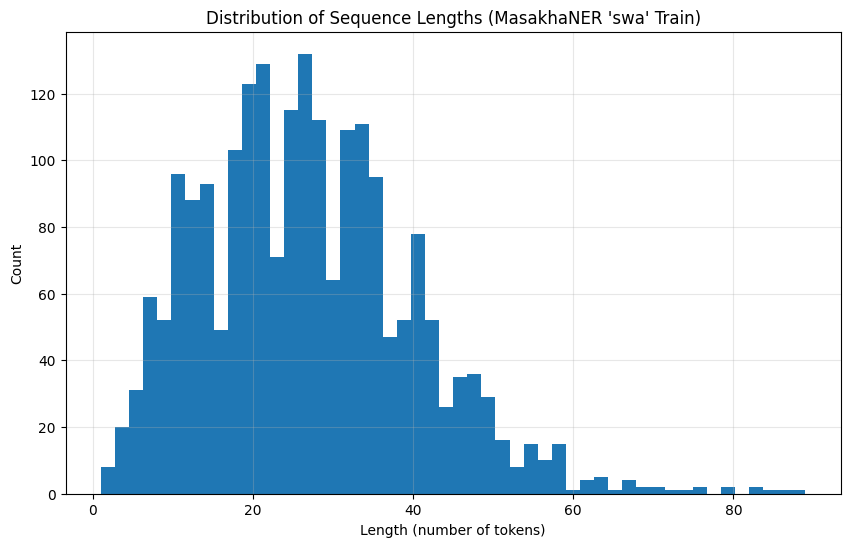

Chosen MAX_LEN based on 95th percentile: 49


Encoding train tokens:   0%|          | 0/2109 [00:00<?, ?it/s]

Encoding train tags:   0%|          | 0/2109 [00:00<?, ?it/s]

Encoding val tokens:   0%|          | 0/300 [00:00<?, ?it/s]

Encoding val tags:   0%|          | 0/300 [00:00<?, ?it/s]

Encoding test tokens:   0%|          | 0/604 [00:00<?, ?it/s]

Encoding test tags:   0%|          | 0/604 [00:00<?, ?it/s]

Data encoding complete! Example token sequence: tensor([ 357,    2,  115,    2,   65,  728,  148,   12,    3,   16,  310,  358,
          36, 2517,   64])...
Example tag sequence: tensor([3, 4, 4, 4, 4, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0])...


In [39]:
# Analyze sequence lengths
seq_lengths = [len(tokens) for tokens in train_tokens_list]
plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50)
plt.title("Distribution of Sequence Lengths (MasakhaNER 'swa' Train)")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

MAX_LEN = int(np.percentile(seq_lengths, 95)) # Using 95th percentile
print(f"Chosen MAX_LEN based on 95th percentile: {MAX_LEN}")

def encode_tokens(tokens, word_to_idx, max_len):
    encoded = [word_to_idx.get(token, word_to_idx[UNK_TOKEN]) for token in tokens[:max_len]]
    padding_length = max_len - len(encoded)
    encoded.extend([PAD_IDX_WORD] * padding_length)
    return encoded

def encode_tags(tags, max_len): # Tags are already integers from dataset
    encoded = tags[:max_len]
    padding_length = max_len - len(encoded)
    encoded.extend([PAD_TAG_IDX] * padding_length) # Use PAD_TAG_IDX for padding labels
    return encoded

train_encoded_tokens = [encode_tokens(tokens, word_to_idx, MAX_LEN) for tokens in tqdm(train_tokens_list, desc="Encoding train tokens")]
train_encoded_tags = [encode_tags(tags, MAX_LEN) for tags in tqdm(train_tags_list, desc="Encoding train tags")]

val_encoded_tokens = [encode_tokens(tokens, word_to_idx, MAX_LEN) for tokens in tqdm(val_tokens_list, desc="Encoding val tokens")]
val_encoded_tags = [encode_tags(tags, MAX_LEN) for tags in tqdm(val_tags_list, desc="Encoding val tags")]

test_encoded_tokens = [encode_tokens(tokens, word_to_idx, MAX_LEN) for tokens in tqdm(test_tokens_list, desc="Encoding test tokens")]
test_encoded_tags = [encode_tags(tags, MAX_LEN) for tags in tqdm(test_tags_list, desc="Encoding test tags")]

# Convert to tensors
train_sequences_tensor = torch.tensor(train_encoded_tokens, dtype=torch.long)
train_labels_tensor = torch.tensor(train_encoded_tags, dtype=torch.long)

val_sequences_tensor = torch.tensor(val_encoded_tokens, dtype=torch.long)
val_labels_tensor = torch.tensor(val_encoded_tags, dtype=torch.long)

test_sequences_tensor = torch.tensor(test_encoded_tokens, dtype=torch.long)
test_labels_tensor = torch.tensor(test_encoded_tags, dtype=torch.long)

print(f"Data encoding complete! Example token sequence: {train_sequences_tensor[0][:15]}...")
print(f"Example tag sequence: {train_labels_tensor[0][:15]}...")

In [40]:
class NERDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = NERDataset(train_sequences_tensor, train_labels_tensor)
val_dataset = NERDataset(val_sequences_tensor, val_labels_tensor)
test_dataset = NERDataset(test_sequences_tensor, test_labels_tensor)

BATCH_SIZE = 32 # Reduced batch size for potentially larger model/data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"DataLoaders created! Training batches: {len(train_loader)}")

DataLoaders created! Training batches: 66


In [41]:
class SequenceTaggerLSTM(nn.Module):
    def __init__(self, vocab_size_words, embedding_dim, hidden_dim, output_dim_tags, 
                 n_layers=1, bidirectional=True, dropout=0.5, pad_idx_words=0):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size_words, embedding_dim, padding_idx=pad_idx_words)
        
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim_tags)
        
    def forward(self, text_seq):
        # text_seq shape: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(text_seq)) # Apply dropout to embeddings
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # lstm_out shape: [batch_size, seq_len, hidden_dim * num_directions]
        
        lstm_out_dropout = self.dropout(lstm_out)
        
        predictions = self.fc(lstm_out_dropout)
        # predictions shape: [batch_size, seq_len, output_dim_tags]
        
        return predictions

# Model Hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128 # Can be tuned
N_LAYERS = 1 # Can be tuned
BIDIRECTIONAL = True
DROPOUT = 0.3 # Can be tuned

model = SequenceTaggerLSTM(
    vocab_size_words=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim_tags=output_dim_many_to_many,
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx_words=PAD_IDX_WORD
)

model = model.to(device)
print(f"SequenceTaggerLSTM model created and moved to {device}!")
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

SequenceTaggerLSTM model created and moved to cuda!
SequenceTaggerLSTM(
  (embedding): Embedding(9187, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)
The model has 1,156,533 trainable parameters


In [42]:
# Optimizer
optimizer = optim.Adam(model.parameters())

# Loss Function: CrossEntropyLoss, ignoring the PAD_TAG_IDX in labels
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_IDX) # PAD_TAG_IDX is 0 ('O')

criterion = criterion.to(device)
print("Loss function (CrossEntropyLoss with ignore_index) and optimizer defined!")

Loss function (CrossEntropyLoss with ignore_index) and optimizer defined!


In [43]:
def train_epoch(model, iterator, optimizer, criterion, pad_tag_idx):
    model.train()
    epoch_loss = 0
    total_correct_preds = 0
    total_preds_count = 0
    
    for batch in tqdm(iterator, desc="Training", leave=False):
        tokens, tags = batch
        tokens = tokens.to(device)
        tags = tags.to(device) # tags shape: [batch_size, seq_len]
        
        optimizer.zero_grad()
        
        predictions = model(tokens)
        # predictions shape: [batch_size, seq_len, output_dim_tags]
        
        # Reshape for CrossEntropyLoss:
        # Input: (N, C) where C = num_classes. Target: (N)
        # predictions_reshaped: [batch_size * seq_len, output_dim_tags]
        # tags_reshaped: [batch_size * seq_len]
        predictions_reshaped = predictions.view(-1, predictions.shape[-1])
        tags_reshaped = tags.view(-1)
        
        loss = criterion(predictions_reshaped, tags_reshaped)
        
        # Accuracy calculation (ignoring PAD_TAG_IDX)
        predicted_classes = torch.argmax(predictions, dim=2) # [batch_size, seq_len]
        
        non_pad_mask = (tags != pad_tag_idx)
        correct_preds = (predicted_classes == tags) & non_pad_mask
        
        total_correct_preds += correct_preds.sum().item()
        total_preds_count += non_pad_mask.sum().item()
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(iterator)
    avg_acc = total_correct_preds / total_preds_count if total_preds_count > 0 else 0
    return avg_loss, avg_acc

In [44]:
def evaluate_epoch(model, iterator, criterion, pad_tag_idx):
    model.eval()
    epoch_loss = 0
    total_correct_preds = 0
    total_preds_count = 0
    
    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating", leave=False):
            tokens, tags = batch
            tokens = tokens.to(device)
            tags = tags.to(device)
            
            predictions = model(tokens)
            
            predictions_reshaped = predictions.view(-1, predictions.shape[-1])
            tags_reshaped = tags.view(-1)
            
            loss = criterion(predictions_reshaped, tags_reshaped)
            
            predicted_classes = torch.argmax(predictions, dim=2)
            non_pad_mask = (tags != pad_tag_idx)
            correct_preds = (predicted_classes == tags) & non_pad_mask
            
            total_correct_preds += correct_preds.sum().item()
            total_preds_count += non_pad_mask.sum().item()
            epoch_loss += loss.item()
            
    avg_loss = epoch_loss / len(iterator)
    avg_acc = total_correct_preds / total_preds_count if total_preds_count > 0 else 0
    return avg_loss, avg_acc

In [45]:
from datasets import load_dataset

# Download the dataset
dataset = load_dataset("imdb")

# Get train and test data
train_data = dataset["train"]
test_data = dataset["test"]

# Display sample data
print(f"Dataset loaded! Total training examples: {len(train_data)}")
print(f"Sample review (text): {train_data[0]['text'][:100]}...")
print(f"Sample label (0=negative, 1=positive): {train_data[0]['label']}")


Dataset loaded! Total training examples: 25000
Sample review (text): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Sample label (0=negative, 1=positive): 0


In [49]:
N_EPOCHS = 20 # Adjust as needed
best_valid_loss = float('inf')

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(N_EPOCHS):
    print(f"\nEpoch {epoch+1}/{N_EPOCHS}")
    print("-" * 20)
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, PAD_TAG_IDX)
    valid_loss, valid_acc = evaluate_epoch(model, val_loader, criterion, PAD_TAG_IDX)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ner_lstm_model.pt')
        print(f"\tSAVED best model (epoch {epoch+1})")

    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

print("\nTraining complete!")


Epoch 1/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	SAVED best model (epoch 1)
	Train Loss: 0.149 | Train Acc: 95.17%
	 Val. Loss: 1.072 |  Val. Acc: 76.65%

Epoch 2/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	SAVED best model (epoch 2)
	Train Loss: 0.138 | Train Acc: 95.85%
	 Val. Loss: 1.011 |  Val. Acc: 76.32%

Epoch 3/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.128 | Train Acc: 96.02%
	 Val. Loss: 1.045 |  Val. Acc: 75.44%

Epoch 4/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.110 | Train Acc: 96.56%
	 Val. Loss: 1.017 |  Val. Acc: 77.42%

Epoch 5/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.097 | Train Acc: 97.12%
	 Val. Loss: 1.206 |  Val. Acc: 74.78%

Epoch 6/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.088 | Train Acc: 97.48%
	 Val. Loss: 1.101 |  Val. Acc: 75.99%

Epoch 7/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.079 | Train Acc: 97.80%
	 Val. Loss: 1.119 |  Val. Acc: 75.66%

Epoch 8/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.073 | Train Acc: 98.13%
	 Val. Loss: 1.106 |  Val. Acc: 77.42%

Epoch 9/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.070 | Train Acc: 97.96%
	 Val. Loss: 1.170 |  Val. Acc: 76.43%

Epoch 10/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.059 | Train Acc: 98.27%
	 Val. Loss: 1.141 |  Val. Acc: 76.65%

Epoch 11/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.058 | Train Acc: 98.36%
	 Val. Loss: 1.154 |  Val. Acc: 78.30%

Epoch 12/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.046 | Train Acc: 98.75%
	 Val. Loss: 1.078 |  Val. Acc: 78.30%

Epoch 13/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.046 | Train Acc: 98.77%
	 Val. Loss: 1.130 |  Val. Acc: 78.08%

Epoch 14/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.047 | Train Acc: 98.83%
	 Val. Loss: 1.085 |  Val. Acc: 78.30%

Epoch 15/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.036 | Train Acc: 99.06%
	 Val. Loss: 1.181 |  Val. Acc: 78.08%

Epoch 16/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.035 | Train Acc: 99.07%
	 Val. Loss: 1.138 |  Val. Acc: 77.75%

Epoch 17/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.035 | Train Acc: 99.09%
	 Val. Loss: 1.079 |  Val. Acc: 77.86%

Epoch 18/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.033 | Train Acc: 99.14%
	 Val. Loss: 1.161 |  Val. Acc: 77.53%

Epoch 19/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.031 | Train Acc: 99.20%
	 Val. Loss: 1.156 |  Val. Acc: 78.08%

Epoch 20/20
--------------------


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.031 | Train Acc: 99.14%
	 Val. Loss: 1.136 |  Val. Acc: 79.41%

Training complete!


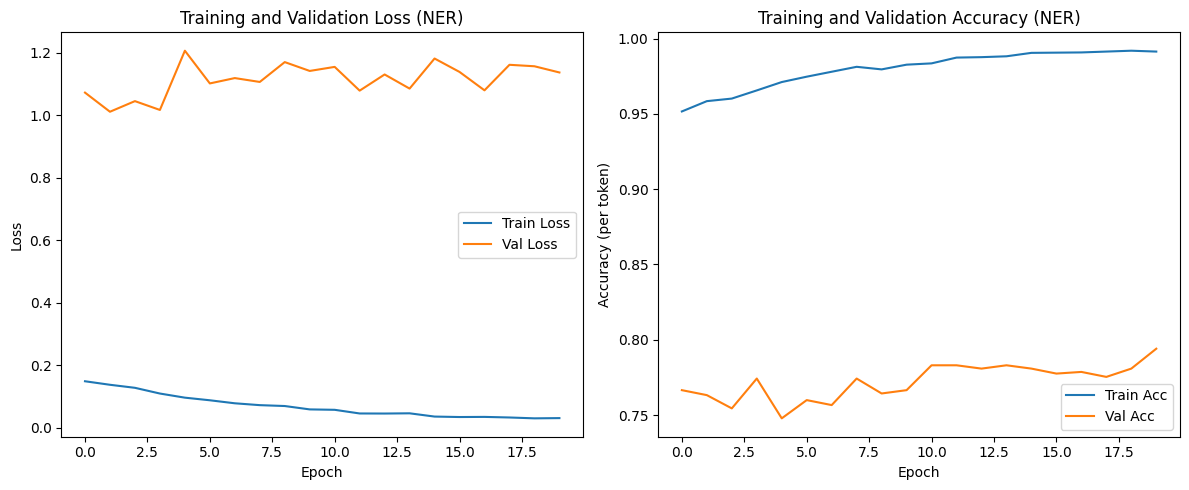

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (NER)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (per token)')
plt.title('Training and Validation Accuracy (NER)')
plt.legend()

plt.tight_layout()
plt.show()

Task :
1. train a 1/3 layered network and compare the results
2. change the task from many to one to many to many tasK